<a href="https://colab.research.google.com/github/erlanggadewa/Sentiment-Analysis-Review-Steam/blob/distilbert/distilbert/transform/1e-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visit **ChrisMcCormickAI** on YouTube for more explanation.
[Image Reference](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=86C9objaKu8f)

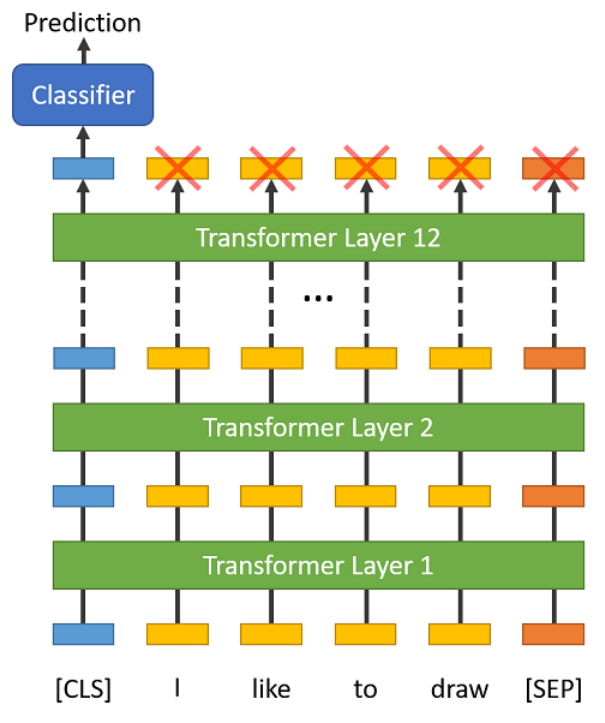

## **1. Cek resource**

In [ ]:
import torch

model_name = 'distilbert_t'
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [2]:
!pip install transformers

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=6d62f581ba0062843676fc5c8874a6fb6cc42f2b6b572a86ccbf0da0cc1b2b45
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## **2. Download & load dataset**

In [4]:
import wget
import os

print("Downloading dataset...")

url = 'https://github.com/erlanggadewa/Sentiment-Analysis-Review-Steam/releases/download/production/final-dataset.csv'

if not os.path.exists('./dataset.csv'):
  wget.download(url, './dataset.csv')

In [5]:
import pandas as pd

df = pd.read_csv("./dataset.csv", delimiter=',')
df.shape

(10000, 3)

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the punkt_tab resource, which was likely missing
nltk.download('punkt_tab')


# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# 0. Convert to String
def convert_to_string(text):
    return str(text)

# 1. Punctuation Removal
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# 2. Case Folding
def case_folding(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# 3. Stopword Removal and Lemmatization
def preprocess_text(text):
    word_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Convert list of words back to string
    return ' '.join(lemmatized_words)

# Full preprocessing pipeline
def full_preprocessing(text):
    text = convert_to_string(text)
    text = remove_punctuation(text)
    text = case_folding(text)
    text = preprocess_text(text)  # Process text: remove stopwords and lemmatize
    return text

# Apply preprocessing to your dataframe
df["review"] = df["review"].apply(full_preprocessing)

# Save the final processed text to a CSV file
df.to_csv("clean-dataset.csv", index=False)
df = pd.read_csv("clean-dataset.csv", delimiter=",")
df.sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,label,sentiment,review
188,Negative,0,absolutely boring uninstall almost first try g...
7006,Positive,1,good fun good voice acting good writing
9247,Positive,1,performance great mid range build rtx 3070 107...
1401,Negative,0,game still trash
8888,Positive,1,way game getting popular recently deluxe editi...


<ipython-input-7-3638a25a03c5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors


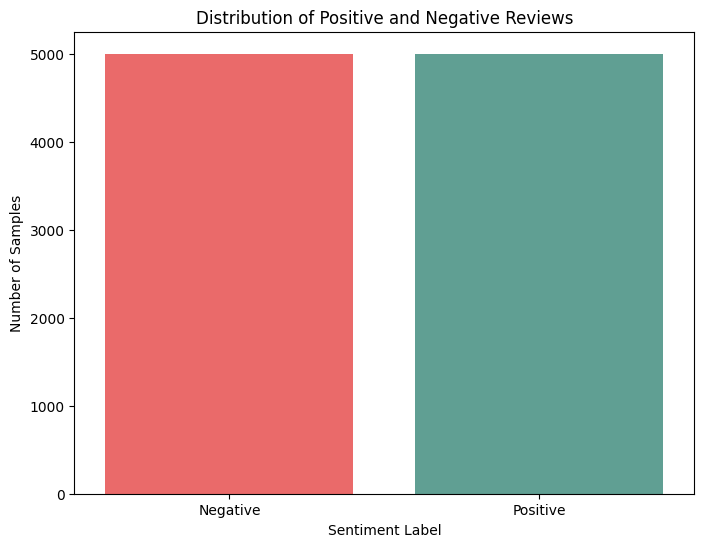

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


In [8]:
sentences = df.review.values
labels = df.label.values
sentiments = df.sentiment.values

## **3. Load DistilBERT Tokenizer**

In [9]:
from transformers import DistilBertTokenizer

print("Loading DistilBERT Tokenizer")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Loading DistilBERT Tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
df.sample(5)

,label,sentiment,review
9871,Positive,1,game design dialogue story choice great game g...
5045,Positive,1,strictly talking game technical issue scummy c...
7926,Positive,1,would call visual story pick outcome love jour...
2229,Negative,0,want start saying veteran soulsborne player kn...
1316,Negative,0,game crash loading screen nothing tried fix mu...


In [11]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


Original:  tutorial show key prompt xbox controller even though using k game crashed every single time matter reached first bonfire asked refund game properly patched might try
Tokenized:  ['tutor', '##ial', 'show', 'key', 'prompt', 'xbox', 'controller', 'even', 'though', 'using', 'k', 'game', 'crashed', 'every', 'single', 'time', 'matter', 'reached', 'first', 'bonfire', 'asked', 'ref', '##und', 'game', 'properly', 'patch', '##ed', 'might', 'try']
Token IDS:  [14924, 4818, 2265, 3145, 25732, 12202, 11486, 2130, 2295, 2478, 1047, 2208, 8007, 2296, 2309, 2051, 3043, 2584, 2034, 28698, 2356, 25416, 8630, 2208, 7919, 8983, 2098, 2453, 3046]


In [12]:
input_ids = []

for sent in sentences:
  # Check if sent is not nan before encoding
  if isinstance(sent, str) and sent != 'nan':
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Original:  tutorial show key prompt xbox controller even though using k game crashed every single time matter reached first bonfire asked refund game properly patched might try
Token IDs:  [101, 14924, 4818, 2265, 3145, 25732, 12202, 11486, 2130, 2295, 2478, 1047, 2208, 8007, 2296, 2309, 2051, 3043, 2584, 2034, 28698, 2356, 25416, 8630, 2208, 7919, 8983, 2098, 2453, 3046, 102]


Max length: 952
Average length: 55.80694555644516
95th percentile: 228.0


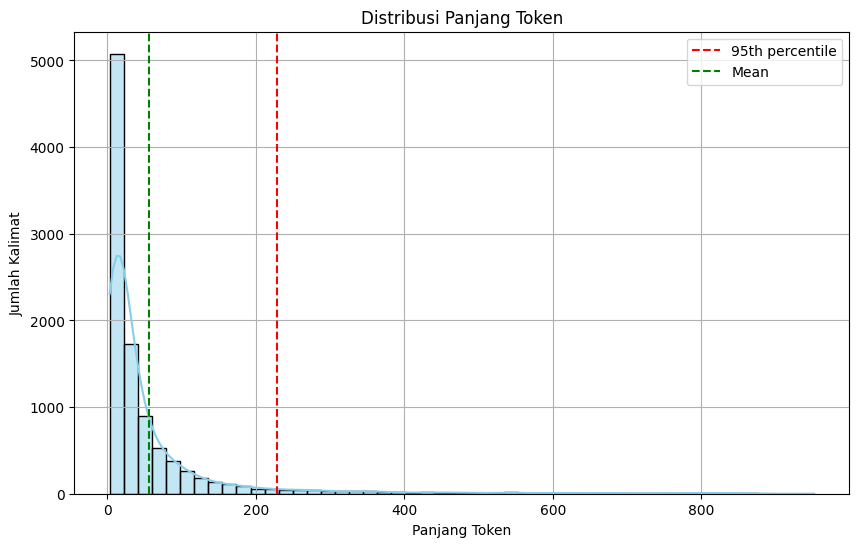

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Hitung panjang setiap tokenized input
lengths = [len(ids) for ids in input_ids]

# Statistik dasar
print("Max length:", np.max(lengths))
print("Average length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='--', label='95th percentile')
plt.axvline(np.mean(lengths), color='green', linestyle='--', label='Mean')
plt.title('Distribusi Panjang Token')
plt.xlabel('Panjang Token')
plt.ylabel('Jumlah Kalimat')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper Bound:", upper_bound)

avg_input_id_length = math.ceil(upper_bound)


Q1: 9.0
Q3: 54.0
IQR: 45.0
Upper Bound: 121.5


In [15]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 512

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 122 values
Padding token: "[PAD]", ID: 0
Done


In [16]:
input_ids[80]

array([  101,  2355,  2145, 11486,  2490,  3602,  2672,  2490, 11486,
       11233, 10958,  6290, 25653, 19392,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [17]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)


## **4. Persiapkan data**

In [18]:
from sklearn.model_selection import train_test_split

# Sinkronisasi awal
num_samples = min(len(input_ids), len(sentiments), len(attention_mask))
input_ids = input_ids[:num_samples]
sentiments = sentiments[:num_samples]
attention_mask = attention_mask[:num_samples]

# Split pertama: train-test
train_input, test_input, train_sentiments, test_sentiments, train_mask, test_mask = train_test_split(
    input_ids,
    sentiments,
    attention_mask,
    stratify=sentiments,
    random_state=2017,
    test_size=0.1
)

# Split kedua: train-validation
train_input, validation_input, train_sentiments, validation_sentiments, train_mask, validation_mask = train_test_split(
    train_input,
    train_sentiments,
    train_mask,
    stratify=train_sentiments,
    random_state=2017,
    test_size=0.15
)


In [19]:
from collections import Counter

print("Train:", Counter(train_sentiments))
print("Validation:", Counter(validation_sentiments))
print("Test:", Counter(test_sentiments))


Train: Counter({np.int64(0): 3825, np.int64(1): 3818})
Validation: Counter({np.int64(0): 675, np.int64(1): 674})
Test: Counter({np.int64(0): 500, np.int64(1): 500})


<ipython-input-20-6b5835b518d1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors


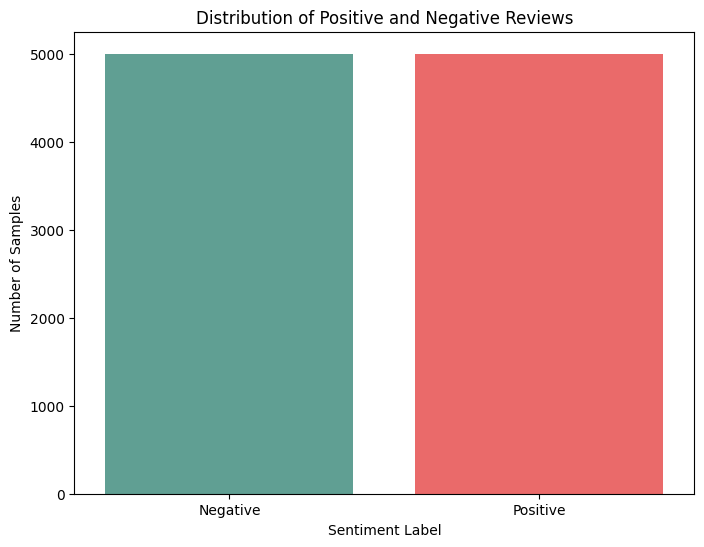

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


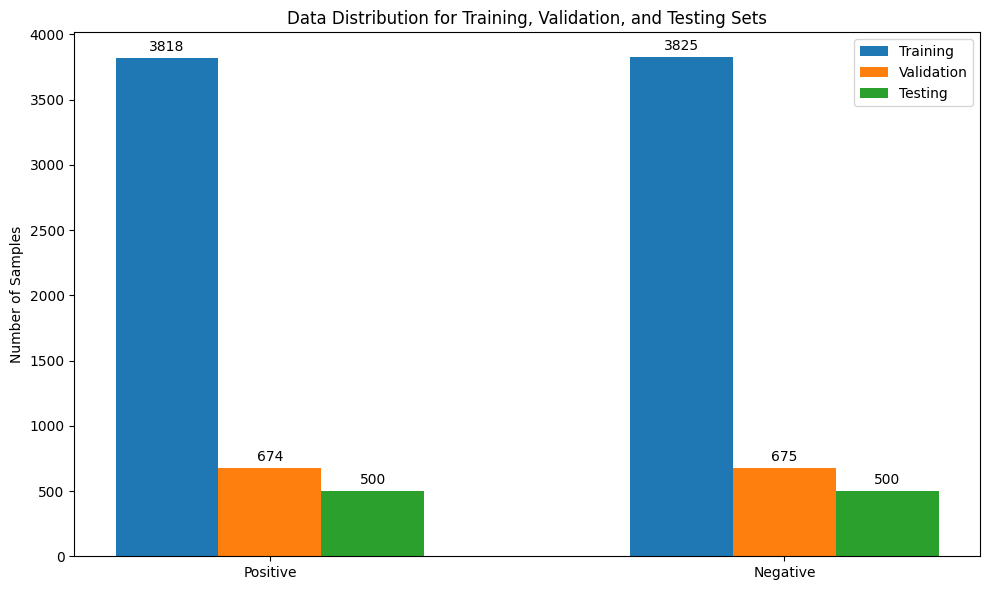

In [21]:

import matplotlib.pyplot as plt
import numpy as np


# Data for the plot (replace with your actual data)
data = {
    'Training': {'Positive': len(train_sentiments[train_sentiments == 1]), 'Negative': len(train_sentiments[train_sentiments == 0])},
    'Validation': {'Positive': len(validation_sentiments[validation_sentiments == 1]), 'Negative': len(validation_sentiments[validation_sentiments == 0])},
    'Testing': {'Positive': len(test_sentiments[test_sentiments == 1]), 'Negative': len(test_sentiments[test_sentiments == 0])}
}

# Create the bar plot
labels = ['Positive', 'Negative']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data['Training'].values(), width, label='Training')
rects2 = ax.bar(x, data['Validation'].values(), width, label='Validation')
rects3 = ax.bar(x + width, data['Testing'].values(), width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Data Distribution for Training, Validation, and Testing Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [22]:

# Calculate the number of samples for each label in each dataset
train_df = pd.DataFrame({'label': train_sentiments})
validation_df = pd.DataFrame({'label': validation_sentiments})
test_df = pd.DataFrame({'label': test_sentiments})

train_counts = train_df['label'].value_counts()
validation_counts = validation_df['label'].value_counts()
test_counts = test_df['label'].value_counts()


# Print the counts for each dataset
print("Training Data:")
print(train_counts)
print("\nValidation Data:")
print(validation_counts)
print("\nTesting Data:")
print(test_counts)

# Create a summary table
summary_data = {'Dataset': ['Training', 'Validation', 'Testing'],
                'Positive': [train_counts.get(1, 0), validation_counts.get(1, 0), test_counts.get(1, 0)],
                'Negative': [train_counts.get(0, 0), validation_counts.get(0, 0), test_counts.get(0, 0)]}
summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
summary_df

Training Data:
label
0    3825
1    3818
Name: count, dtype: int64

Validation Data:
label
0    675
1    674
Name: count, dtype: int64

Testing Data:
label
0    500
1    500
Name: count, dtype: int64

Summary Table:


,Dataset,Positive,Negative
0,Training,3818,3825
1,Validation,674,675
2,Testing,500,500


In [23]:
train_input = torch.tensor(train_input)
train_sentiments = torch.tensor(train_sentiments)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_sentiments = torch.tensor(validation_sentiments)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_sentiments = torch.tensor(test_sentiments)
test_mask = torch.tensor(test_mask)

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_data = TensorDataset(train_input, train_mask, train_sentiments)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_sentiments)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_sentiments)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **5. Persiapkan model pre-trained DistilBERT**

In [25]:
from transformers import  DistilBertForSequenceClassification, RobertaConfig
from torch.optim import AdamW  # Tetap sama

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
params = list(model.named_parameters())

print("The DistilBERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The DistilBERT model has 104 different named parameters.
==== Embedding Layer ====
distilbert.embeddings.word_embeddings.weight                 (30522, 768)
distilbert.embeddings.position_embeddings.weight               (512, 768)
distilbert.embeddings.LayerNorm.weight                             (768,)
distilbert.embeddings.LayerNorm.bias                               (768,)
distilbert.transformer.layer.0.attention.q_lin.weight          (768, 768)
==== First Transformers ====
distilbert.transformer.layer.0.attention.q_lin.bias                (768,)
distilbert.transformer.layer.0.attention.k_lin.weight          (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias                (768,)
distilbert.transformer.layer.0.attention.v_lin.weight          (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias                (768,)
distilbert.transformer.layer.0.attention.out_lin.weight        (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias              (768,)


In [27]:
learning_rate = 1e-5;
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = 1e-8
)

In [28]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [29]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **6. Training DistilBERT**

======= Epoch 1 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:23
Batch    80 of   120.     Elapsed: 0:00:45
   Average training loss: 0.4420
   Training epoch took: 0:01:09

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       675
           1       0.90      0.87      0.89       674

    accuracy                           0.89      1349
   macro avg       0.89      0.89      0.89      1349
weighted avg       0.89      0.89      0.89      1349

   MCC (Validation): 0.7751
   Confusion Matrix (Validation):
      TN: 610, FP: 65, FN: 87, TP: 587


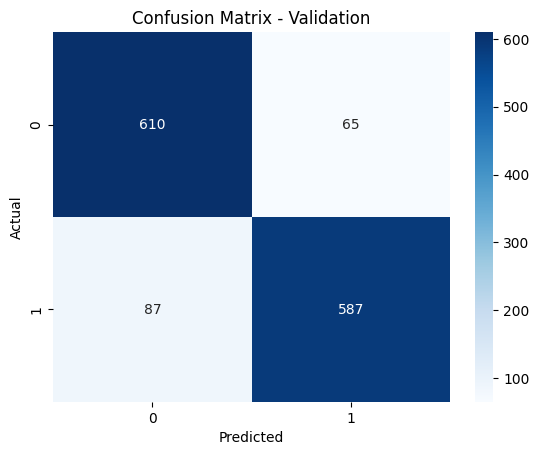

   Validation Accuracy: 0.8837
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       500
           1       0.89      0.87      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

   MCC (Testing): 0.7602
   Confusion Matrix (Testing):
      TN: 446, FP: 54, FN: 66, TP: 434


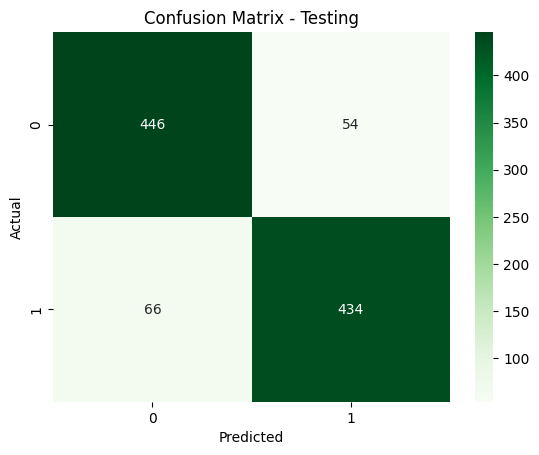

   Test Accuracy: 0.8793
   Testing took: 0:00:04

======= Epoch 2 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.2375
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       675
           1       0.88      0.91      0.90       674

    accuracy                           0.89      1349
   macro avg       0.89      0.89      0.89      1349
weighted avg       0.89      0.89      0.89      1349

   MCC (Validation): 0.7885
   Confusion Matrix (Validation):
      TN: 592, FP: 83, FN: 60, TP: 614


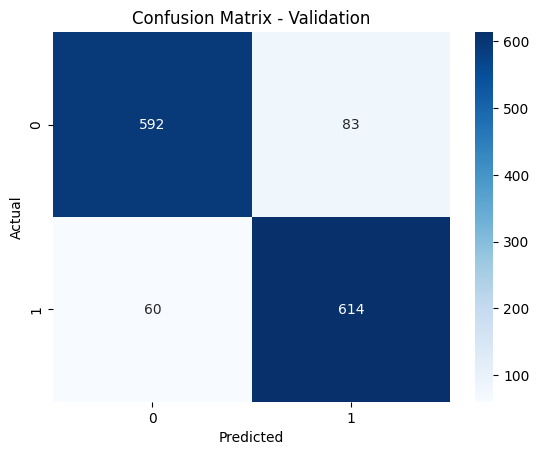

   Validation Accuracy: 0.8901
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       500
           1       0.88      0.92      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.7948
   Confusion Matrix (Testing):
      TN: 437, FP: 63, FN: 40, TP: 460


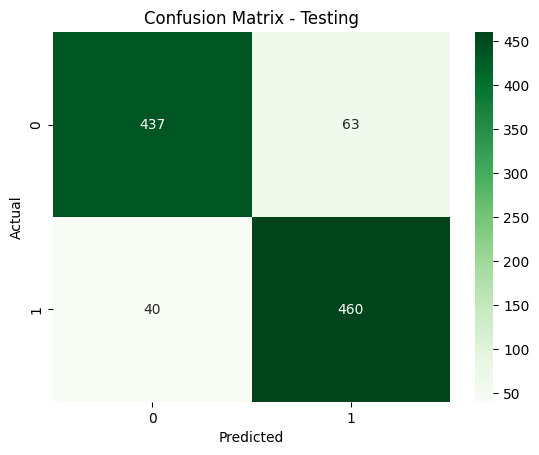

   Test Accuracy: 0.8953
   Testing took: 0:00:03

======= Epoch 3 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.1877
   Training epoch took: 0:01:12

Running Validation...
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       675
           1       0.90      0.89      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.7940
   Confusion Matrix (Validation):
      TN: 610, FP: 65, FN: 74, TP: 600


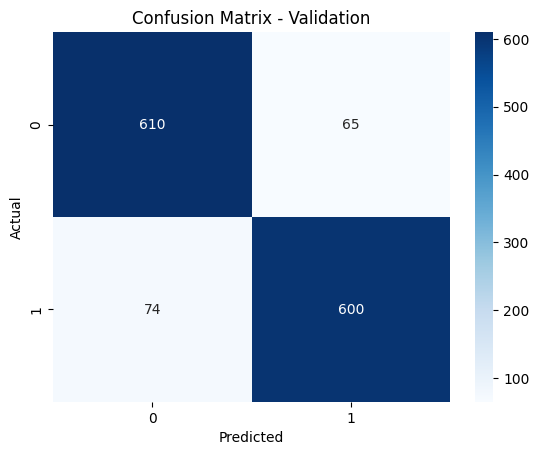

   Validation Accuracy: 0.8929
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       500
           1       0.91      0.90      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

   MCC (Testing): 0.8122
   Confusion Matrix (Testing):
      TN: 458, FP: 42, FN: 52, TP: 448


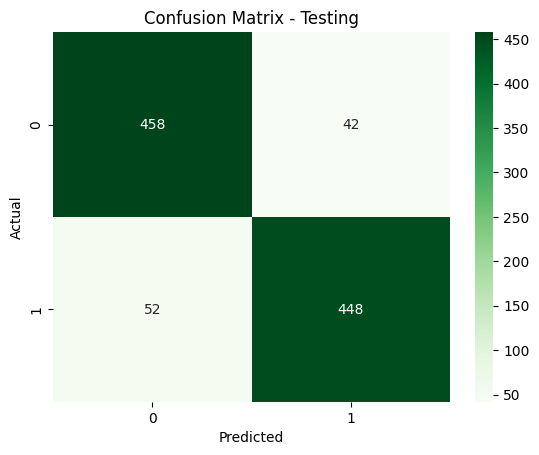

   Test Accuracy: 0.9041
   Testing took: 0:00:03

======= Epoch 4 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.1564
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       675
           1       0.90      0.92      0.91       674

    accuracy                           0.91      1349
   macro avg       0.91      0.91      0.91      1349
weighted avg       0.91      0.91      0.91      1349

   MCC (Validation): 0.8119
   Confusion Matrix (Validation):
      TN: 605, FP: 70, FN: 57, TP: 617


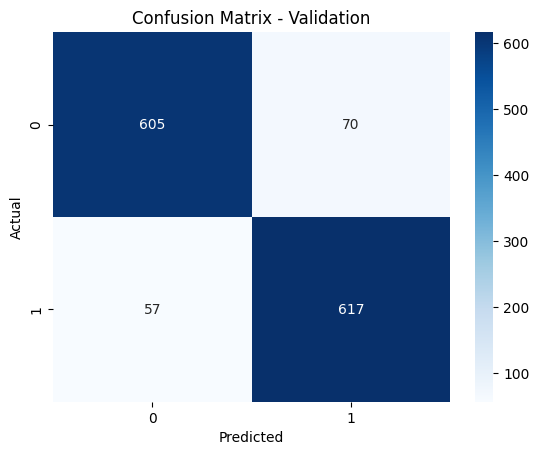

   Validation Accuracy: 0.9014
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       500
           1       0.90      0.92      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

   MCC (Testing): 0.8163
   Confusion Matrix (Testing):
      TN: 447, FP: 53, FN: 39, TP: 461


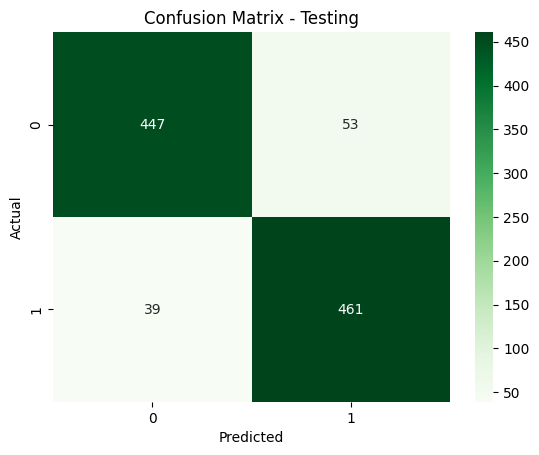

   Test Accuracy: 0.9066
   Testing took: 0:00:03

======= Epoch 5 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.1286
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       675
           1       0.92      0.88      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8023
   Confusion Matrix (Validation):
      TN: 625, FP: 50, FN: 84, TP: 590


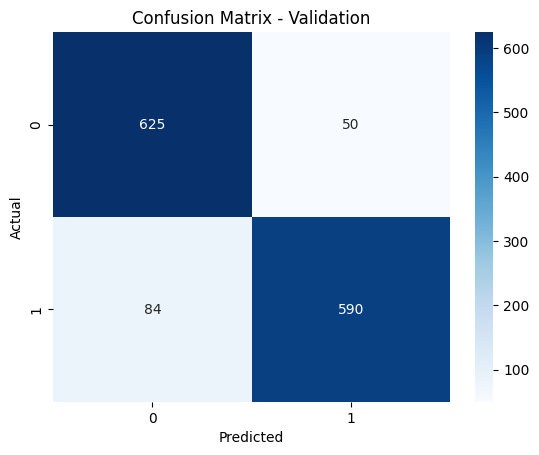

   Validation Accuracy: 0.8964
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       500
           1       0.93      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

   MCC (Testing): 0.8232
   Confusion Matrix (Testing):
      TN: 469, FP: 31, FN: 58, TP: 442


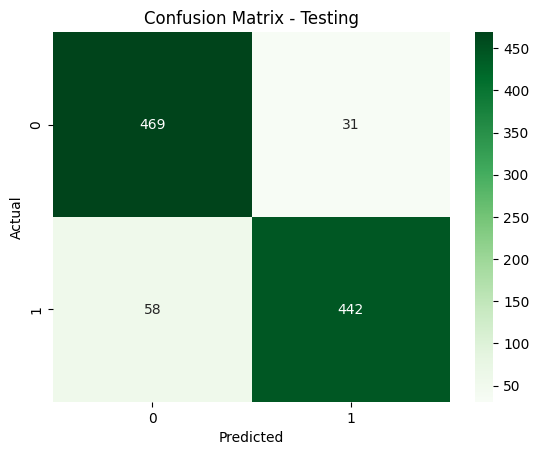

   Test Accuracy: 0.9096
   Testing took: 0:00:03

======= Epoch 6 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.1048
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       675
           1       0.90      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8073
   Confusion Matrix (Validation):
      TN: 611, FP: 64, FN: 66, TP: 608


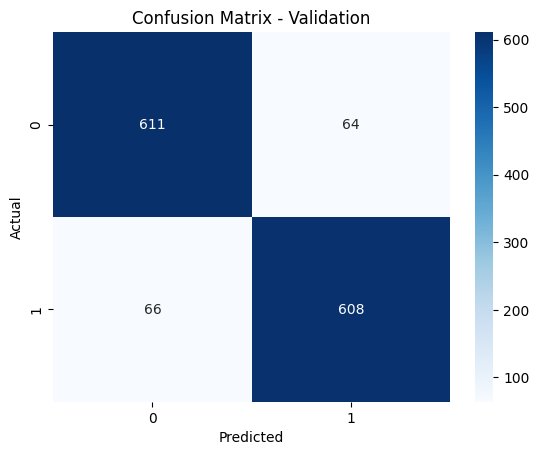

   Validation Accuracy: 0.8993
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       500
           1       0.92      0.91      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

   MCC (Testing): 0.8260
   Confusion Matrix (Testing):
      TN: 459, FP: 41, FN: 46, TP: 454


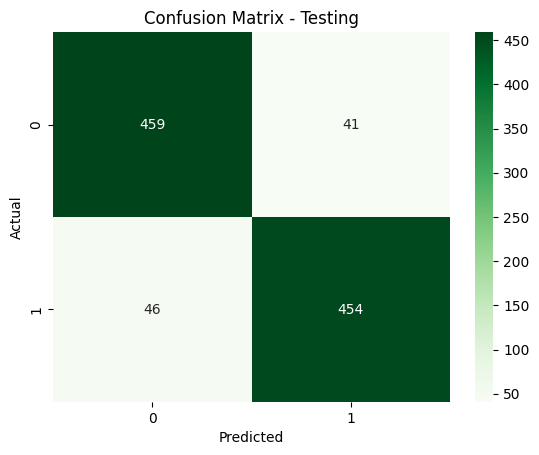

   Test Accuracy: 0.9109
   Testing took: 0:00:03

======= Epoch 7 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.0906
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       675
           1       0.91      0.89      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8030
   Confusion Matrix (Validation):
      TN: 615, FP: 60, FN: 73, TP: 601


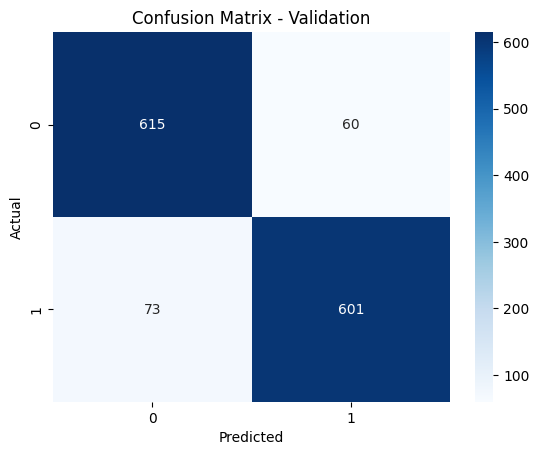

   Validation Accuracy: 0.8972
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       500
           1       0.92      0.92      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

   MCC (Testing): 0.8400
   Confusion Matrix (Testing):
      TN: 462, FP: 38, FN: 42, TP: 458


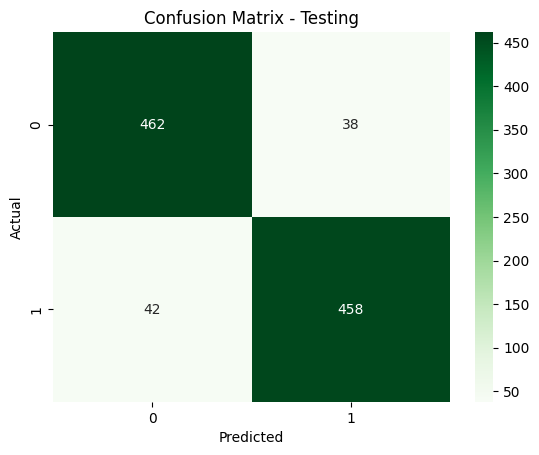

   Test Accuracy: 0.9189
   Testing took: 0:00:04

======= Epoch 8 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.0793
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       675
           1       0.90      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8087
   Confusion Matrix (Validation):
      TN: 611, FP: 64, FN: 65, TP: 609


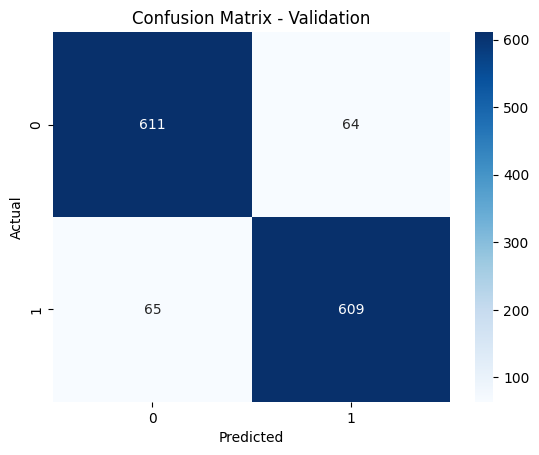

   Validation Accuracy: 0.9000
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       500
           1       0.91      0.93      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

   MCC (Testing): 0.8361
   Confusion Matrix (Testing):
      TN: 455, FP: 45, FN: 37, TP: 463


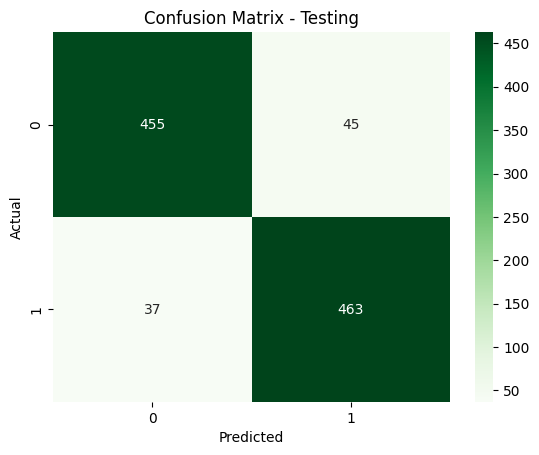

   Test Accuracy: 0.9164
   Testing took: 0:00:03

======= Epoch 9 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:48
   Average training loss: 0.0733
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       675
           1       0.91      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8088
   Confusion Matrix (Validation):
      TN: 613, FP: 62, FN: 67, TP: 607


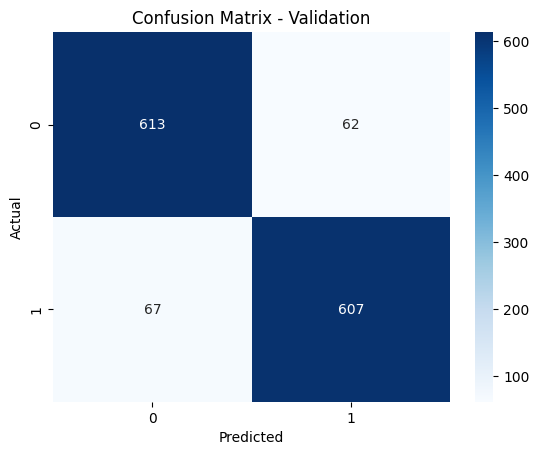

   Validation Accuracy: 0.9000
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       500
           1       0.91      0.92      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

   MCC (Testing): 0.8321
   Confusion Matrix (Testing):
      TN: 454, FP: 46, FN: 38, TP: 462


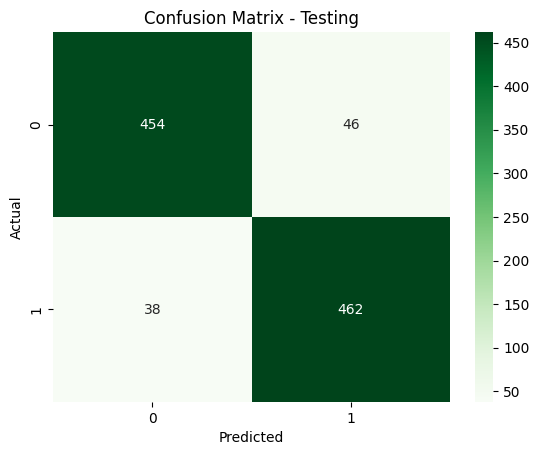

   Test Accuracy: 0.9145
   Testing took: 0:00:03

======= Epoch 10 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:24
Batch    80 of   120.     Elapsed: 0:00:47
   Average training loss: 0.0652
   Training epoch took: 0:01:11

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       675
           1       0.91      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.8088
   Confusion Matrix (Validation):
      TN: 614, FP: 61, FN: 68, TP: 606


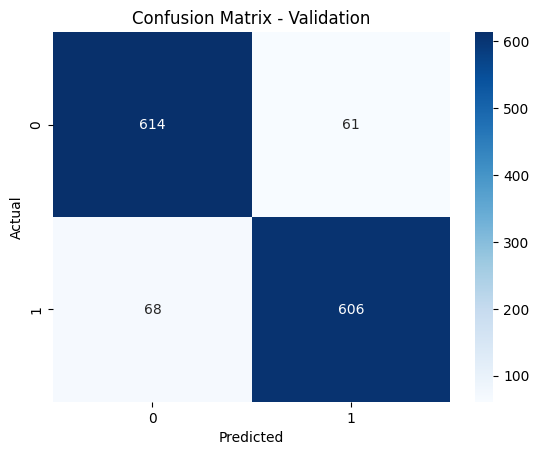

   Validation Accuracy: 0.9000
   Validation took: 0:00:05

Running Testing...
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       500
           1       0.91      0.92      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.92      0.92      0.91      1000

   MCC (Testing): 0.8300
   Confusion Matrix (Testing):
      TN: 456, FP: 44, FN: 41, TP: 459


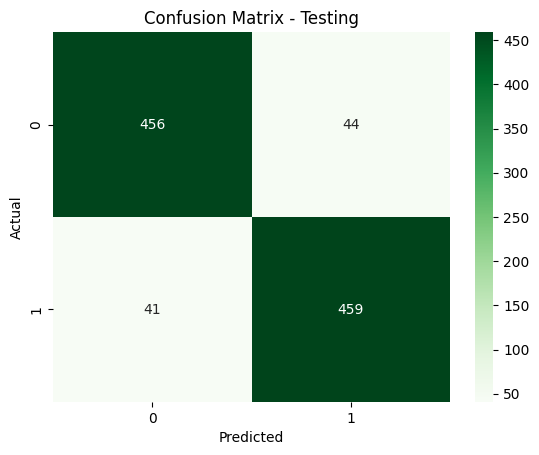

   Test Accuracy: 0.9135
   Testing took: 0:00:03

Log training per epoch disimpan di 'training_logs.csv'
Training complete!
Total training time: 0:11:52


In [ ]:
import random
import time
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, f1_score

# Setup seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Simpan history dan log
loss_values = []
validation_accuracies = []
test_accuracies = []
epoch_logs = []

total_training_time = 0
model.to(device)


# Format nama file untuk CSV
lr_str = str(learning_rate).replace('.', 'p').replace('-', 'm')
filename = f"{model_name}_{lr_str}.csv"

for epoch_i in range(0, epochs):
    print("======= Epoch {:} / {:} =======".format(epoch_i + 1, epochs))
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    epoch_training_time = time.time() - t0
    total_training_time += epoch_training_time

    print("   Average training loss: {0:.4f}".format(avg_train_loss))
    print("   Training epoch took: {:}".format(format_time(epoch_training_time)))

    # ============================
    #        VALIDATION
    # ============================
    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0
    all_preds_val = []
    all_labels_val = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_val.extend(preds)
        all_labels_val.extend(label_ids)

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    validation_accuracies.append(avg_val_accuracy)

    report_val = classification_report(all_labels_val, all_preds_val, output_dict=True)
    macro_precision_val = report_val['macro avg']['precision']
    macro_recall_val = report_val['macro avg']['recall']
    macro_f1_val = report_val['macro avg']['f1-score']
    print(classification_report(all_labels_val, all_preds_val))

    mcc_val = matthews_corrcoef(all_labels_val, all_preds_val)
    print("   MCC (Validation): {:.4f}".format(mcc_val))
    print("   F1 Score (Validation - Macro): {:.4f}".format(macro_f1_val))

    # ============================
    #          TESTING
    # ============================
    print("\nRunning Testing...")
    t0 = time.time()
    model.eval()

    test_accuracy = 0
    nb_test_steps = 0
    all_preds_test = []
    all_labels_test = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        test_accuracy += tmp_test_accuracy
        nb_test_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_test.extend(preds)
        all_labels_test.extend(label_ids)

    avg_test_accuracy = test_accuracy / nb_test_steps
    test_accuracies.append(avg_test_accuracy)

    report_test = classification_report(all_labels_test, all_preds_test, output_dict=True)
    macro_precision_test = report_test['macro avg']['precision']
    macro_recall_test = report_test['macro avg']['recall']
    macro_f1_test = report_test['macro avg']['f1-score']
    print(classification_report(all_labels_test, all_preds_test))

    mcc_test = matthews_corrcoef(all_labels_test, all_preds_test)
    print("   MCC (Testing): {:.4f}".format(mcc_test))
    print("   F1 Score (Testing - Macro): {:.4f}".format(macro_f1_test))

    # ============================
    #     LOG PER EPOCH
    # ============================
    epoch_logs.append({
        "epoch": epoch_i + 1,
        "train_loss": avg_train_loss,
        "val_accuracy": avg_val_accuracy,
        "val_mcc": mcc_val,
        "val_macro_precision": macro_precision_val,
        "val_macro_recall": macro_recall_val,
        "val_macro_f1": macro_f1_val,
        "test_accuracy": avg_test_accuracy,
        "test_mcc": mcc_test,
        "test_macro_precision": macro_precision_test,
        "test_macro_recall": macro_recall_test,
        "test_macro_f1": macro_f1_test,
    })

# Simpan ke CSV
df_logs = pd.DataFrame(epoch_logs)
df_logs.to_csv(filename, index=False)
print(f"Log training per epoch disimpan di '{filename}'")

print("Training complete!")
print("Total training time: {:}".format(format_time(total_training_time)))


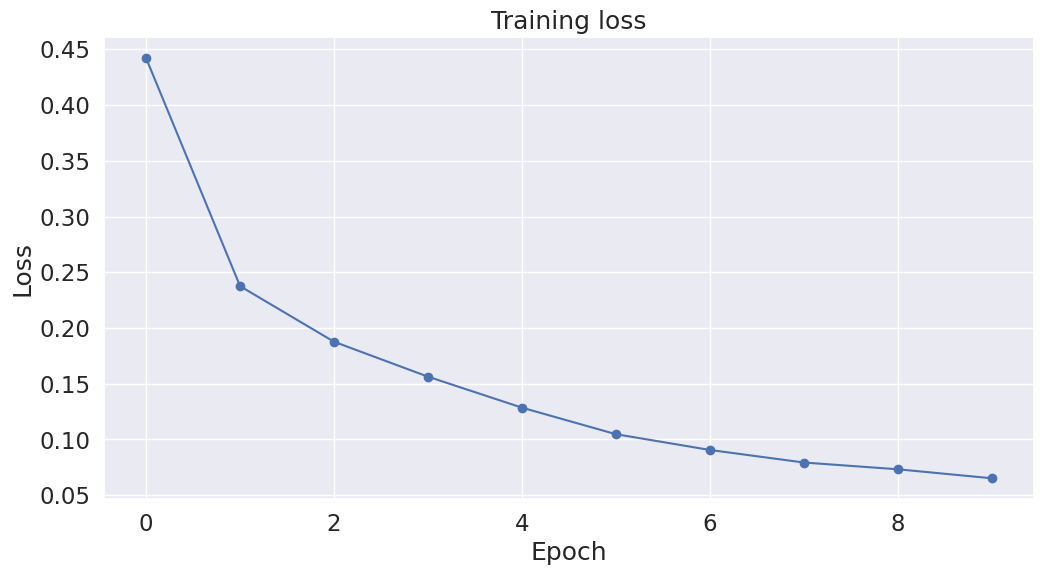

In [32]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **7. Predict dan Evaluate**

In [33]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,000 test sentences
 DONE.


In [34]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.4f" %mcc)

MCC: 0.8300


In [35]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.4f" %acc)


ACC: 0.9150



Hyperparameters:
- Learning Rate: 1e-05
- Batch Size: 64
- Epochs: 10
MCC: 0.8300
ACC: 0.9150
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       500
           1       0.91      0.92      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.92      0.92      0.91      1000



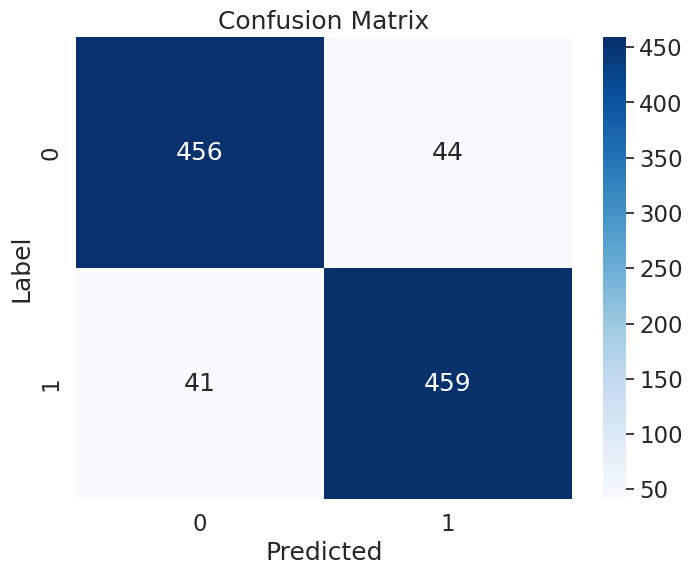

In [36]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Additional information you might want to display:
# * Training time per epoch
# * Hyperparameters used (learning rate, batch size, epochs, etc.)
# * Number of training examples
# * Number of validation examples
# * Number of test examples
# * Model architecture details
# * Other relevant metrics, e.g., precision, recall, F1-score (if applicable)

# Example of displaying hyperparameters
print("\nHyperparameters:")
print(f"- Learning Rate: {learning_rate}")  # Replace with your actual learning rate
print(f"- Batch Size: {batch_size}") # Replace with your actual batch size
print(f"- Epochs: {epochs}") # Replace with your actual epoch number

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)
print("MCC: %.4f" % mcc)

acc = accuracy_score(flat_true_labels, flat_prediction)
print("ACC: %.4f" % acc)

# Generate classification report
print(classification_report(flat_true_labels, flat_prediction))

# Generate and plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.title("Confusion Matrix")
plt.show()